# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
C:\Users\MCUT\anaconda3\envs\class\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\MCUT\anaconda3\envs\class\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\MCUT\anaconda3\envs\class\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\MCUT\anaconda3\envs\class\lib\site-packag

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [12]:
"""
Build your own model
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


In [13]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [0.1, 0.01, 0.001, 0.0001]
EPOCHS = 50
BATCH_SIZE = 256
OPTIMIZER = [keras.optimizers.SGD, keras.optimizers.RMSprop, keras.optimizers.Adagrad, keras.optimizers.Adam]


In [16]:
import itertools
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
for opti, lr in itertools.product(OPTIMIZER, LEARNING_RATE):
# 把舊的 Graph 清掉
    keras.backend.clear_session()
    print(f"Experiment with LR = {lr}, Optimizer = {opti}" )
    model = build_mlp(input_shape = x_train.shape[-1:])
    model.summary()
    
    optimizer = opti(lr = lr)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer = optimizer)\
    
    model.fit(x_train, y_train,
             epochs = EPOCHS,
             batch_size = BATCH_SIZE,
             validation_data = (x_test, y_test),
             shuffle = True)
    
    train_loss = model.history.history['loss']
    validation_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    validation_loss = model.history.history['val_acc']
    
    exp_name_tag = f"exp-lr-{lr}-optimizer-{opti}"
    results[exp_name_tag] = {'train_loss': train_loss,
                            'validation_loss': validation_loss, 
                            'train_acc': train_acc,
                            'validation_acc': validation_loss}

Experiment with LR = 0.1, Optimizer = <class 'keras.optimizers.SGD'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 39us/step - loss: 2.0801 - acc: 0.2603 - val_loss: 1.9548 - val_acc: 0.3214
Epoch 2/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.8956 - acc: 0.3343 - val_loss: 1.8930 - val_acc: 0.3189
Epoch 3/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.8231 - acc: 0.3609 - val_loss: 1.8364 - val_acc: 0.3550
Epoch 4/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.7763 - acc: 0.3768 - val_loss: 1.7563 - val_acc: 0.3792
Epoch 5/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.7407 - acc: 0.3870 - val_loss: 1.8594 - val_acc: 0.3489
Epoch 6/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.7122 - acc: 0.3975 - val_loss: 1.7321 - val_acc: 0.3833
Epoch 7/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.6859 - acc: 0.4065 - val_loss: 1.7286 - val_acc

Epoch 2/50
50000/50000 [==============================] - 2s 36us/step - loss: 2.1704 - acc: 0.2337 - val_loss: 2.1358 - val_acc: 0.2494
Epoch 3/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.1078 - acc: 0.2622 - val_loss: 2.0814 - val_acc: 0.2679
Epoch 4/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.0574 - acc: 0.2790 - val_loss: 2.0374 - val_acc: 0.2867
Epoch 5/50
50000/50000 [==============================] - 2s 34us/step - loss: 2.0178 - acc: 0.2939 - val_loss: 2.0034 - val_acc: 0.3010
Epoch 6/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.9871 - acc: 0.3050 - val_loss: 1.9766 - val_acc: 0.3065
Epoch 7/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.9625 - acc: 0.3131 - val_loss: 1.9538 - val_acc: 0.3141
Epoch 8/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.9420 - acc: 0.3215 - val_loss: 1.9354 - val_acc: 0.3219
Epoch 9/50
50000/50000 [=================

50000/50000 [==============================] - 2s 35us/step - loss: 2.2907 - acc: 0.1286 - val_loss: 2.2817 - val_acc: 0.1316
Epoch 4/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.2749 - acc: 0.1351 - val_loss: 2.2685 - val_acc: 0.1379
Epoch 5/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.2638 - acc: 0.1407 - val_loss: 2.2585 - val_acc: 0.1440
Epoch 6/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.2549 - acc: 0.1477 - val_loss: 2.2501 - val_acc: 0.1542
Epoch 7/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.2470 - acc: 0.1559 - val_loss: 2.2423 - val_acc: 0.1628
Epoch 8/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.2395 - acc: 0.1649 - val_loss: 2.2349 - val_acc: 0.1696
Epoch 9/50
50000/50000 [==============================] - 2s 35us/step - loss: 2.2322 - acc: 0.1702 - val_loss: 2.2275 - val_acc: 0.1777
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 41us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 41us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 41us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 2s 41us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 2s 41us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000 [============

50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 41us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 2s 41us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000 [============

50000/50000 [==============================] - 2s 40us/step - loss: 1.7094 - acc: 0.3883 - val_loss: 1.6374 - val_acc: 0.4187
Epoch 5/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.6433 - acc: 0.4113 - val_loss: 1.6905 - val_acc: 0.3924
Epoch 6/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.6043 - acc: 0.4255 - val_loss: 1.7242 - val_acc: 0.4050
Epoch 7/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.5599 - acc: 0.4420 - val_loss: 1.7146 - val_acc: 0.3813
Epoch 8/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.5222 - acc: 0.4553 - val_loss: 1.5484 - val_acc: 0.4506
Epoch 9/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.4866 - acc: 0.4695 - val_loss: 1.7053 - val_acc: 0.3927
Epoch 10/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.4630 - acc: 0.4810 - val_loss: 1.6747 - val_acc: 0.4087
Epoch 11/50
50000/50000 [==========================

50000/50000 [==============================] - 2s 41us/step - loss: 1.6103 - acc: 0.4286 - val_loss: 1.6254 - val_acc: 0.4212
Epoch 6/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.5734 - acc: 0.4417 - val_loss: 1.5835 - val_acc: 0.4331
Epoch 7/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.5391 - acc: 0.4560 - val_loss: 1.6387 - val_acc: 0.4206
Epoch 8/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.5120 - acc: 0.4652 - val_loss: 1.5695 - val_acc: 0.4351
Epoch 9/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.4870 - acc: 0.4751 - val_loss: 1.5810 - val_acc: 0.4394
Epoch 10/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4623 - acc: 0.4825 - val_loss: 1.4903 - val_acc: 0.4677
Epoch 11/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.4435 - acc: 0.4881 - val_loss: 1.5133 - val_acc: 0.4591
Epoch 12/50
50000/50000 [=========================

50000/50000 [==============================] - 2s 39us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 2s 39us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/50
50000/50000 [==========

50000/50000 [==============================] - 2s 39us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 2s 39us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 8/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 2s 41us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 2s 41us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/50
50000/50000 [==============================] - 2s 40us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/50
50000/50000 [==========

Epoch 7/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.5985 - acc: 0.4388 - val_loss: 1.6120 - val_acc: 0.4371
Epoch 8/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.5761 - acc: 0.4487 - val_loss: 1.5915 - val_acc: 0.4454
Epoch 9/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.5585 - acc: 0.4538 - val_loss: 1.5930 - val_acc: 0.4402
Epoch 10/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.5427 - acc: 0.4591 - val_loss: 1.5703 - val_acc: 0.4440
Epoch 11/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.5268 - acc: 0.4662 - val_loss: 1.5441 - val_acc: 0.4534
Epoch 12/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.5126 - acc: 0.4710 - val_loss: 1.5595 - val_acc: 0.4464
Epoch 13/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.5018 - acc: 0.4745 - val_loss: 1.5406 - val_acc: 0.4556
Epoch 14/50
50000/50000 [============

50000/50000 [==============================] - 2s 40us/step - loss: 1.8034 - acc: 0.3747 - val_loss: 1.8004 - val_acc: 0.3771
Epoch 9/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7935 - acc: 0.3783 - val_loss: 1.7931 - val_acc: 0.3765
Epoch 10/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.7848 - acc: 0.3822 - val_loss: 1.7864 - val_acc: 0.3804
Epoch 11/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7772 - acc: 0.3844 - val_loss: 1.7778 - val_acc: 0.3849
Epoch 12/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7704 - acc: 0.3864 - val_loss: 1.7718 - val_acc: 0.3886
Epoch 13/50
50000/50000 [==============================] - 2s 40us/step - loss: 1.7640 - acc: 0.3895 - val_loss: 1.7653 - val_acc: 0.3912
Epoch 14/50
50000/50000 [==============================] - 2s 39us/step - loss: 1.7579 - acc: 0.3925 - val_loss: 1.7594 - val_acc: 0.3911
Epoch 15/50
50000/50000 [======================

50000/50000 [==============================] - 2s 43us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 2s 43us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 2s 43us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/50
50000/50000 [==============================] - 2s 42us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/50
50000/50000 [==============================] - 2s 43us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 14/50
50000/50000 [==============================] - 2s 43us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 15/50
50000/50000 [==============================] - 2s 43us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 16/50
50000/50000 [=======

50000/50000 [==============================] - 2s 42us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 2s 42us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 2s 43us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 12/50
50000/50000 [==============================] - 2s 42us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 13/50
50000/50000 [==============================] - 2s 43us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 14/50
50000/50000 [==============================] - 2s 42us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 15/50
50000/50000 [==============================] - 2s 42us/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 16/50
50000/50000 [=======

Epoch 10/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.3529 - acc: 0.5176 - val_loss: 1.4420 - val_acc: 0.4938
Epoch 11/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.3255 - acc: 0.5293 - val_loss: 1.4026 - val_acc: 0.5036
Epoch 12/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2955 - acc: 0.5369 - val_loss: 1.3831 - val_acc: 0.5118
Epoch 13/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2855 - acc: 0.5398 - val_loss: 1.3988 - val_acc: 0.5036
Epoch 14/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2554 - acc: 0.5509 - val_loss: 1.3935 - val_acc: 0.5065
Epoch 15/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2326 - acc: 0.5605 - val_loss: 1.4500 - val_acc: 0.4973
Epoch 16/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2135 - acc: 0.5679 - val_loss: 1.4234 - val_acc: 0.4974
Epoch 17/50
50000/50000 [=========

50000/50000 [==============================] - 2s 42us/step - loss: 1.3637 - acc: 0.5201 - val_loss: 1.4324 - val_acc: 0.4926
Epoch 12/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.3487 - acc: 0.5249 - val_loss: 1.3995 - val_acc: 0.5031
Epoch 13/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.3219 - acc: 0.5362 - val_loss: 1.3945 - val_acc: 0.5049
Epoch 14/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.3061 - acc: 0.5410 - val_loss: 1.3903 - val_acc: 0.5079
Epoch 15/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2862 - acc: 0.5486 - val_loss: 1.3710 - val_acc: 0.5142
Epoch 16/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2758 - acc: 0.5528 - val_loss: 1.3705 - val_acc: 0.5124
Epoch 17/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2543 - acc: 0.5593 - val_loss: 1.3732 - val_acc: 0.5116
Epoch 18/50
50000/50000 [=====================

Duplicate key in file 'C:\\Users\\MCUT\\anaconda3\\envs\\class\\lib\\site-packages\\matplotlib\\mpl-data\\matplotlibrc' line #250.


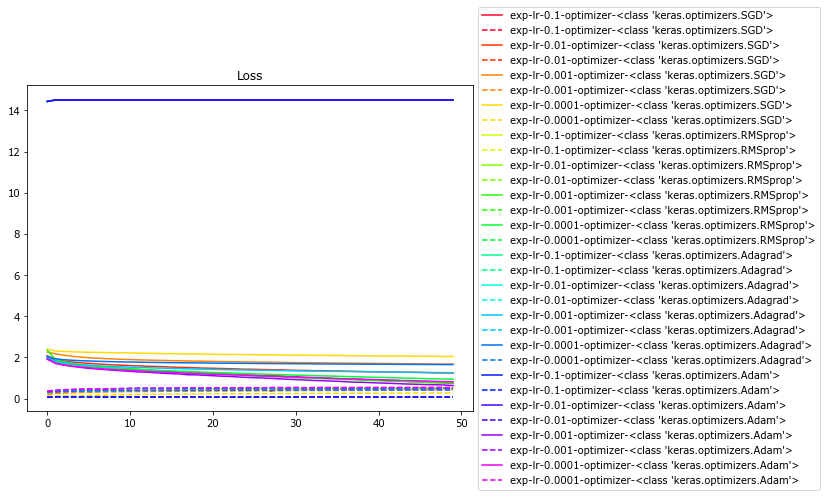

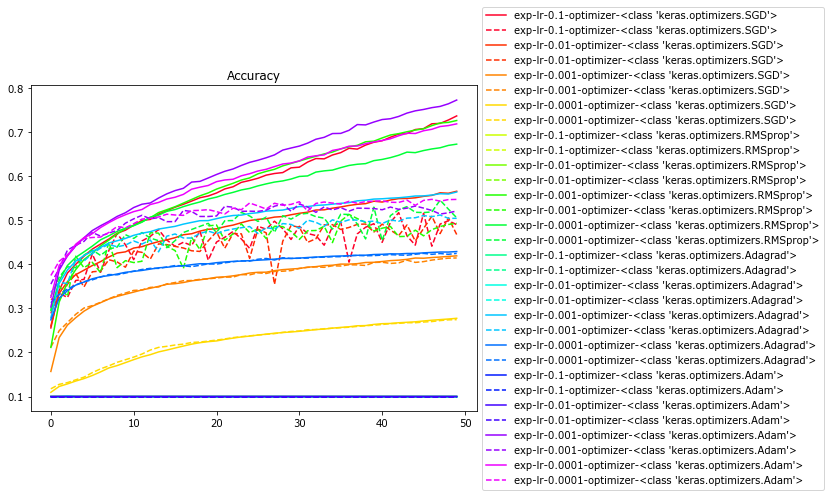

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['validation_loss'])),results[cond]['validation_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['validation_acc'])),results[cond]['validation_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()